In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout


In [2]:
test_folder = "C:\\Users\\Sergey\\Desktop\\WHALE_FINAL\\"
train_folder = test_folder


In [3]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!
torch.backends.cudnn.enabled = False


33616


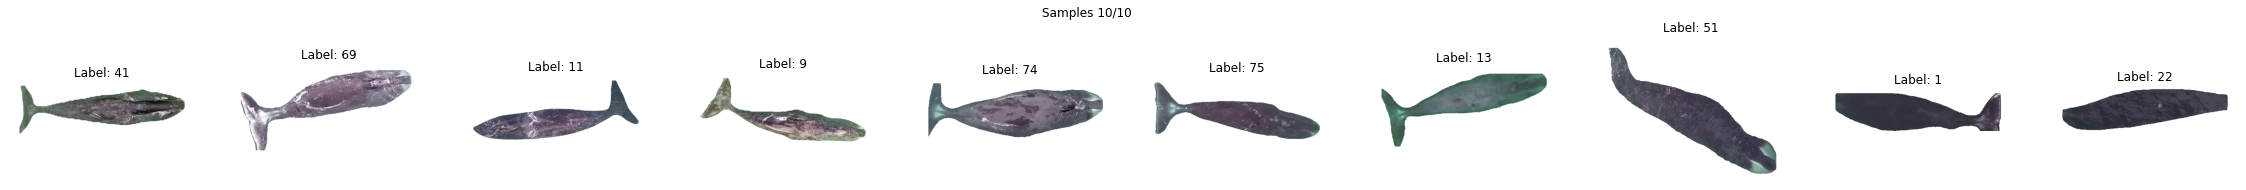

In [4]:

class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):        
        self.transform = transform
        self.folder = folder
        self.files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
        print(len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):        
        img_id = self.files[index]
        img = Image.open(os.path.join(self.folder, img_id))
        mask = Image.open(os.path.join(self.folder, img_id.replace(".jpg", ".png")))
        img = Image.composite(img, Image.new("RGB", img.size, (255, 255, 255)), mask)

        if self.transform:
            img = self.transform(img)
        y = int(img_id.split("_")[0])

        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(40, 3))
    
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
        
    
orig_dataset = HotdogOrNotDataset(train_folder)
count = 10
indices = np.random.choice(np.arange(len(orig_dataset)), count, replace=False)

visualize_samples(orig_dataset, indices, "Samples", count = count)

33616


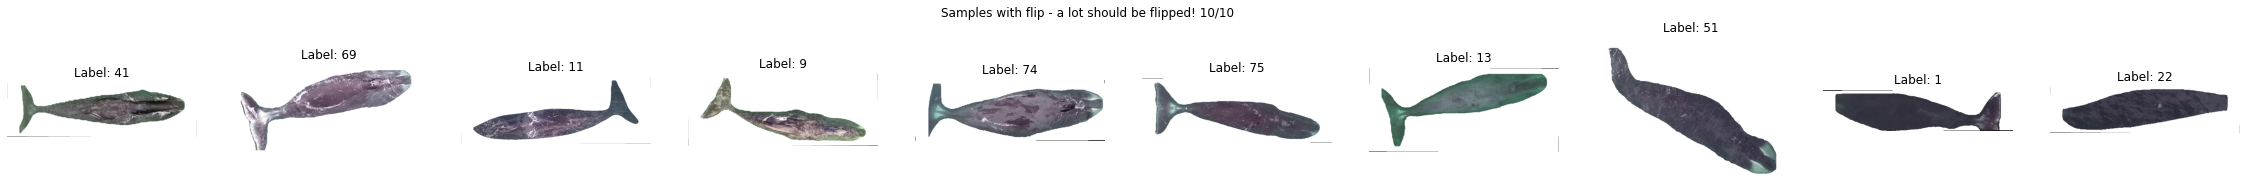

In [5]:
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomAffine(0.5))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

In [6]:
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.GaussianBlur(kernel_size=3), 
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

33616
33616


In [7]:
batch_size = 8

data_size = len(dataset)
validation_fraction = .15


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [9]:
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):

        model.train()

        loss_accum = 0
        total_samples = 0
        f1_average = 0
        for i_step, (x, y,_) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)

            optimizer.zero_grad()
            loss_value.backward()

            optimizer.step()
            
            _, max_val = torch.max(prediction, 1)
            f1_tmp = f1_score(y_gpu.cpu(), max_val.cpu(), average='macro')
            f1_average += f1_tmp
            
            total_samples += y.cpu().shape[0]
            loss_accum += loss_value.detach().cpu()
            if i_step % 2000 == 0:
                print("Step %d, loss: %f" % (i_step, loss_value.detach().cpu()))
                print("Step %d, f1: %f" % (i_step, f1_tmp))

            del loss_value
            del prediction
            del x_gpu
            del y_gpu

        print("Epoch %s. Train loss: %s. Train f1: %s" % (epoch, loss_accum / total_samples, f1_average / total_samples))
        train_f_1 = f1_average / total_samples

        model.eval()
        val_f_1 = 0
        f1_average = 0
        total_sample = 0
        loss_sum = 0
        for x, y,_ in val_loader:
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            loss_sum += loss_value.detach().cpu()
            _, indices = torch.max(prediction, 1)

            f1_average += f1_score(y_gpu.cpu(), indices.cpu(), average='macro')
            total_sample += y_gpu.shape[0]
            loss_value = loss_value.detach()
            del loss_value
            del prediction
            del x_gpu
            del y_gpu
            
        val_f_1 = f1_average / total_sample
        loss_f_1 =  loss_sum / total_sample
        print("Epoch %s. Val loss: %s. Val f1: %s" % (epoch, loss_f_1, val_f_1))

        torch.save(model,
                   'C:\\Users\\Sergey\\Desktop\\MODELS\\' + str(epoch) + "_" + str(train_f_1)[:6] + "_" + str(val_f_1)[:6] + ".pth")
        loss_history.append(loss_accum / total_samples)
        train_history.append(train_f_1)
        val_history.append(val_f_1)


    return loss_history, train_history, val_history




In [12]:
import torch.nn as nn
import torch.optim as optim

model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 103)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=3e-3)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 6)



Step 0, loss: 4.391839
Step 0, f1: 0.044444
Step 2000, loss: 3.135054
Step 2000, f1: 0.116667
Epoch 0. Train loss: tensor(0.4463). Train f1: 0.010483922611356172
Epoch 0. Val loss: tensor(0.2831). Val f1: 0.03279770934620205
Step 0, loss: 2.115203
Step 0, f1: 0.333333
Step 2000, loss: 1.101137
Step 2000, f1: 0.904762
Epoch 1. Train loss: tensor(0.1965). Train f1: 0.05354331392355507
Epoch 1. Val loss: tensor(0.0805). Val f1: 0.0886914767765618
Step 0, loss: 0.956536
Step 0, f1: 0.444444
Step 2000, loss: 0.464797
Step 2000, f1: 0.777778
Epoch 2. Train loss: tensor(0.0811). Train f1: 0.08822396878155697
Epoch 2. Val loss: tensor(0.0362). Val f1: 0.10823633546511366
Step 0, loss: 0.183424
Step 0, f1: 1.000000


KeyboardInterrupt: 

In [13]:
loss_history = [i.item() for i in loss_history]

NameError: name 'loss_history' is not defined

In [19]:
train_history

[0.33998975934459835,
 0.4444444444444443,
 0.48796722990271374,
 0.4792626728110599,
 0.4843830005120328,
 0.49615975422427033,
 0.500768049155146,
 0.500768049155146,
 0.500768049155146,
 0.500768049155146]

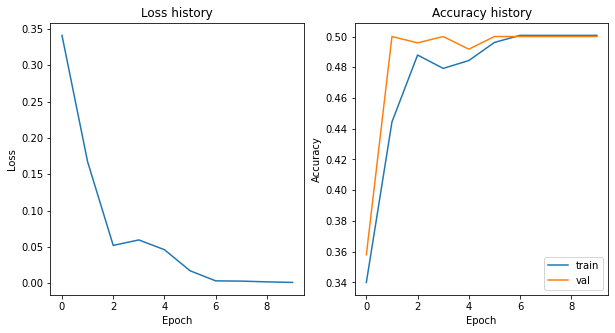

In [20]:
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Loss history")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.title("Accuracy history")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:

import cv2
import pandas as pd
import torch
import segmentation_models_pytorch as smp
import albumentations as albu
import glob
device = torch.device("cuda:0")

model = torch.load(r"C:\Users\Sergey\Desktop\MODELS\resnet50\6_0.4796_0.3058.pth")
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')

import glob
for i in glob.glob(r"C:\Users\Sergey\Desktop\TEST\*.jpg"):
    img_name = i.split("\\")[-1]
    img = cv2.imread(i)
    orig_img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    trf = albu.Compose([albu.Lambda(image=preprocessing_fn)])

    img = trf(image=img)['image']
    img = img.transpose(2, 0, 1).astype('float32')

    x_tensor = torch.from_numpy(img).to("cuda").unsqueeze(0)

    out = model(x_tensor)
    print(out)
    # get top 2 from out
    top_2 = torch.topk(out, 5)
    # get top 2 classes arg
    top_2_arg = top_2.indices.cpu().numpy()[0]
    res = torch.argmax(out)
    print(res)
    print(top_2_arg)
    break

tensor([[-116.4377,  -46.5197, -100.5487,  -93.8661,  -82.2622,  -88.4094,
         -114.7115, -127.9229,  -84.4806,  -67.7001,  -66.6742,  -78.9761,
          -86.2892,  -88.5723, -104.1636,  -60.3277, -106.4091, -154.5746,
          -73.3529,  -80.6665, -112.3054,  -87.9635,  -92.5190, -131.4733,
         -123.8859, -113.0449, -110.9494, -157.7696,  -77.4039,  -88.9085,
         -106.6480, -125.3995,  -99.9036,  -80.5739, -155.8979, -117.8390,
          -89.7405,  -82.4360,  -95.3821,  -79.7975, -102.3746,  -72.7198,
          -68.9024, -113.6996, -133.8697,  -99.5126,  -68.5147, -147.6699,
         -112.7697, -115.8706, -121.8257,  -96.4298, -107.5501, -144.6710,
          -74.6669, -142.7963, -110.1107, -165.7303, -104.4254, -113.5506,
         -114.9350,  -99.3385, -101.4896, -136.2551, -112.5680, -120.6488,
          -85.3463, -167.3330, -125.9562, -167.2321,  -88.9211, -142.0008,
         -127.7320,  -69.2498,  -94.6246, -168.0971,  -71.3753,  -89.8113,
         -125.7077,  -90.